In [1]:
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
from ydata_profiling import ProfileReport
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.metrics as sm
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
from math import fsum, sqrt
from scipy.stats import shapiro
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, TargetEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor

%matplotlib inline

import warnings

warnings.filterwarnings("ignore")

np.random.seed(7)

In [2]:
cars = pd.read_csv('car_data.csv', sep=',')
cars.head()

,Unnamed: 0,car_brand,car_model,car_price,car_city,car_fuel,car_transmission,car_drive,car_mileage,car_country,car_engine_capacity,car_engine_hp,car_age
0,0,Ford,Focus,550000,Astrakhan,gasoline,manual,FWD,300000,USA,1.8,125,14
1,1,Mercedes-Benz,GLA-Class,1820000,Astrakhan,gasoline,robot,FWD,88000,DE,1.6,156,10
2,2,Haval,F7,2600000,Astrakhan,gasoline,robot,4WD,19000,CN,1.5,150,2
3,3,Toyota,Camry,4200000,Astrakhan,gasoline,automatic,FWD,30000,JP,3.5,249,2
4,4,OMODA,C5,2125000,Astrakhan,gasoline,CVT,FWD,18824,CN,1.5,147,2


In [3]:
cars

,Unnamed: 0,car_brand,car_model,car_price,car_city,car_fuel,car_transmission,car_drive,car_mileage,car_country,car_engine_capacity,car_engine_hp,car_age
0,0,Ford,Focus,550000,Astrakhan,gasoline,manual,FWD,300000,USA,1.8,125,14
1,1,Mercedes-Benz,GLA-Class,1820000,Astrakhan,gasoline,robot,FWD,88000,DE,1.6,156,10
2,2,Haval,F7,2600000,Astrakhan,gasoline,robot,4WD,19000,CN,1.5,150,2
3,3,Toyota,Camry,4200000,Astrakhan,gasoline,automatic,FWD,30000,JP,3.5,249,2
4,4,OMODA,C5,2125000,Astrakhan,gasoline,CVT,FWD,18824,CN,1.5,147,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
42084,42084,Isuzu,Bighorn,450000,Yakutsk,diesel,automatic,4WD,183212,JP,3.1,125,30
42085,42085,Toyota,Corolla Axio,650000,Yakutsk,gasoline,CVT,FWD,110000,JP,1.5,110,13
42086,42086,Daihatsu,Be-Go,1350000,Yakutsk,gasoline,automatic,4WD,153000,JP,1.5,109,13
42087,42087,Mazda,Tribute,550000,Yakutsk,gasoline,automatic,4WD,190000,JP,2.0,129,23


In [4]:
cars.drop(['Unnamed: 0', 'car_country', 'car_city'], axis=1, inplace=True)
cars.head()

,car_brand,car_model,car_price,car_fuel,car_transmission,car_drive,car_mileage,car_engine_capacity,car_engine_hp,car_age
0,Ford,Focus,550000,gasoline,manual,FWD,300000,1.8,125,14
1,Mercedes-Benz,GLA-Class,1820000,gasoline,robot,FWD,88000,1.6,156,10
2,Haval,F7,2600000,gasoline,robot,4WD,19000,1.5,150,2
3,Toyota,Camry,4200000,gasoline,automatic,FWD,30000,3.5,249,2
4,OMODA,C5,2125000,gasoline,CVT,FWD,18824,1.5,147,2


In [5]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42089 entries, 0 to 42088
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   car_brand            42089 non-null  object 
 1   car_model            42089 non-null  object 
 2   car_price            42089 non-null  int64  
 3   car_fuel             42089 non-null  object 
 4   car_transmission     42089 non-null  object 
 5   car_drive            42089 non-null  object 
 6   car_mileage          42089 non-null  int64  
 7   car_engine_capacity  42089 non-null  float64
 8   car_engine_hp        42089 non-null  int64  
 9   car_age              42089 non-null  int64  
dtypes: float64(1), int64(4), object(5)
memory usage: 3.2+ MB


In [6]:
cars.drop_duplicates(inplace=True)
cars['car_model'] = cars['car_model'].str.strip()
cars

,car_brand,car_model,car_price,car_fuel,car_transmission,car_drive,car_mileage,car_engine_capacity,car_engine_hp,car_age
0,Ford,Focus,550000,gasoline,manual,FWD,300000,1.8,125,14
1,Mercedes-Benz,GLA-Class,1820000,gasoline,robot,FWD,88000,1.6,156,10
2,Haval,F7,2600000,gasoline,robot,4WD,19000,1.5,150,2
3,Toyota,Camry,4200000,gasoline,automatic,FWD,30000,3.5,249,2
4,OMODA,C5,2125000,gasoline,CVT,FWD,18824,1.5,147,2
...,...,...,...,...,...,...,...,...,...,...
42084,Isuzu,Bighorn,450000,diesel,automatic,4WD,183212,3.1,125,30
42085,Toyota,Corolla Axio,650000,gasoline,CVT,FWD,110000,1.5,110,13
42086,Daihatsu,Be-Go,1350000,gasoline,automatic,4WD,153000,1.5,109,13
42087,Mazda,Tribute,550000,gasoline,automatic,4WD,190000,2.0,129,23


In [7]:
# profile = ProfileReport(
#     cars, title="Pandas Profiling Report for 'Used Car' train dataset"
# )
# profile.to_file("used_car_train_profiling.html")

In [8]:
def distribution():
    plt.figure(figsize=[10, 10])
    plt.suptitle('Distribution')

    plt.subplot(3, 1, 1)
    sns.kdeplot(cars['car_price'])
    plt.xlabel("Price")
    plt.ylabel('Density')
    plt.axvline(cars['car_price'].mean(), label='mean', c='orange')
    plt.axvline(cars['car_price'].quantile(0.90), label='90% quantile', c='blue')
    plt.axvline(cars['car_price'].quantile(0.95), label='95% quantile', c='red')
    plt.axvline(cars['car_price'].quantile(0.99), label='99% quantile', c='violet')
    plt.legend()

    plt.subplot(3, 1, 2)
    sns.kdeplot(cars['car_mileage'])
    plt.xlabel("Mileage")
    plt.ylabel('Density')
    plt.axvline(cars['car_mileage'].mean(), label='mean', c='orange')
    plt.axvline(cars['car_mileage'].quantile(0.90), label='90% quantile', c='blue')
    plt.axvline(cars['car_mileage'].quantile(0.95), label='95% quantile', c='red')
    plt.axvline(cars['car_mileage'].quantile(0.99), label='99% quantile', c='violet')
    plt.legend()

    plt.subplot(3, 1, 3)
    sns.kdeplot(cars['car_age'])
    plt.xlabel("Age")
    plt.ylabel('Density')
    plt.axvline(cars['car_age'].mean(), label='mean', c='orange')
    plt.axvline(cars['car_age'].quantile(0.90), label='90% quantile', c='blue')
    plt.axvline(cars['car_age'].quantile(0.95), label='95% quantile', c='red')
    plt.axvline(cars['car_age'].quantile(0.99), label='99% quantile', c='violet')
    plt.legend()

    plt.tight_layout()
    plt.show()

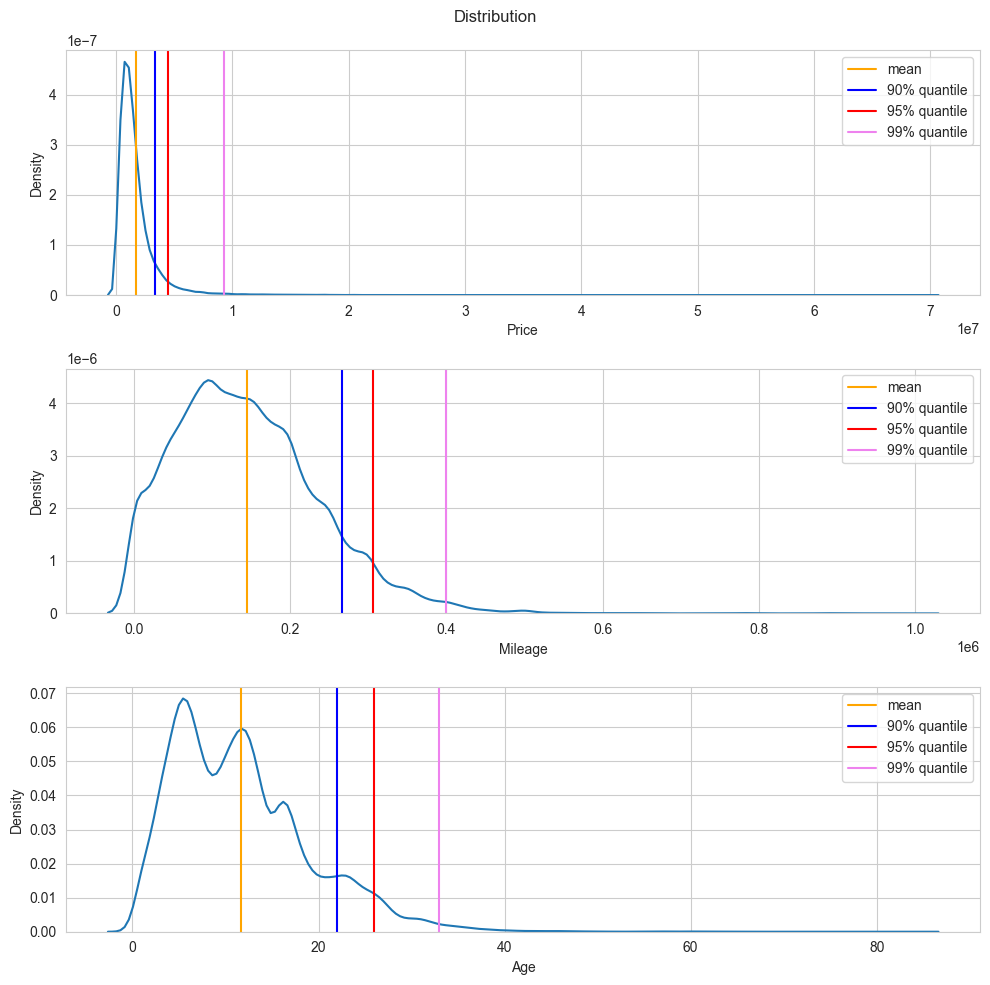

In [9]:
distribution()

4500000.0


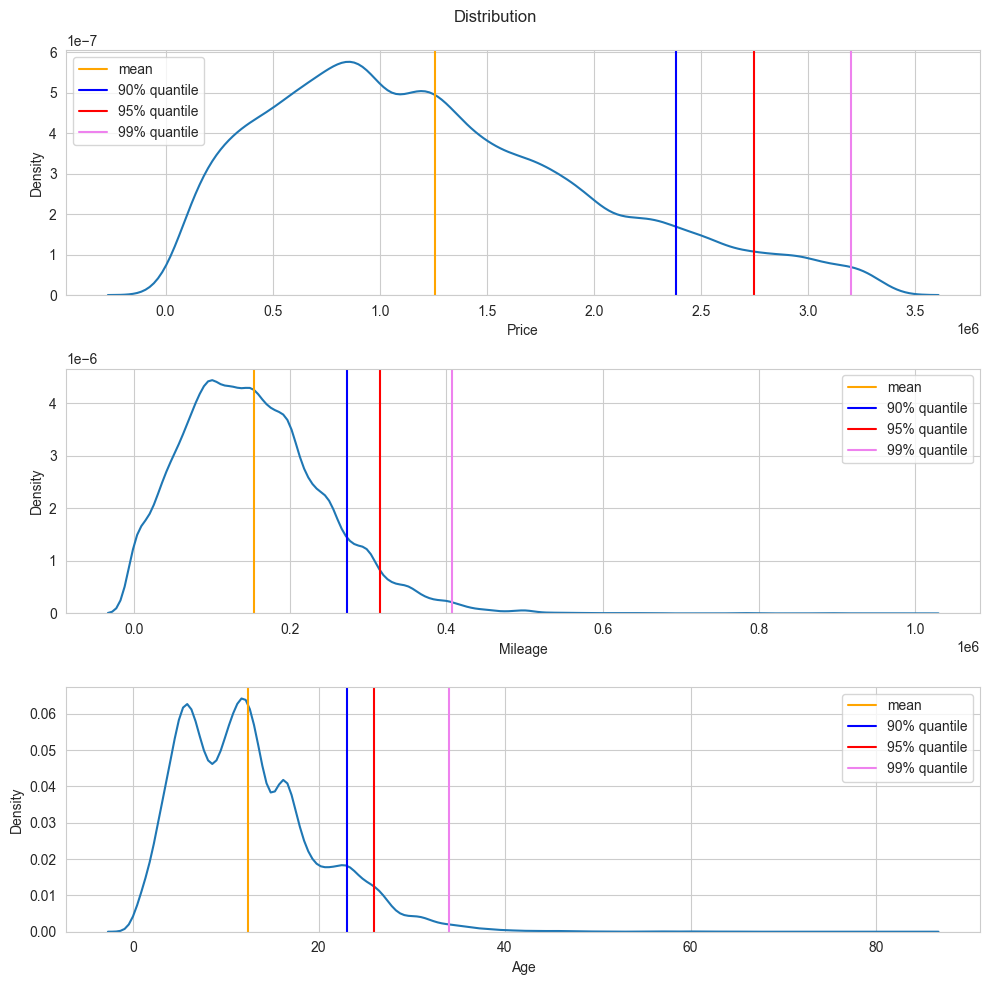

In [10]:
print(cars['car_price'].quantile(0.95))
cars = cars.loc[cars['car_price'] < cars['car_price'].quantile(0.90)]
distribution()

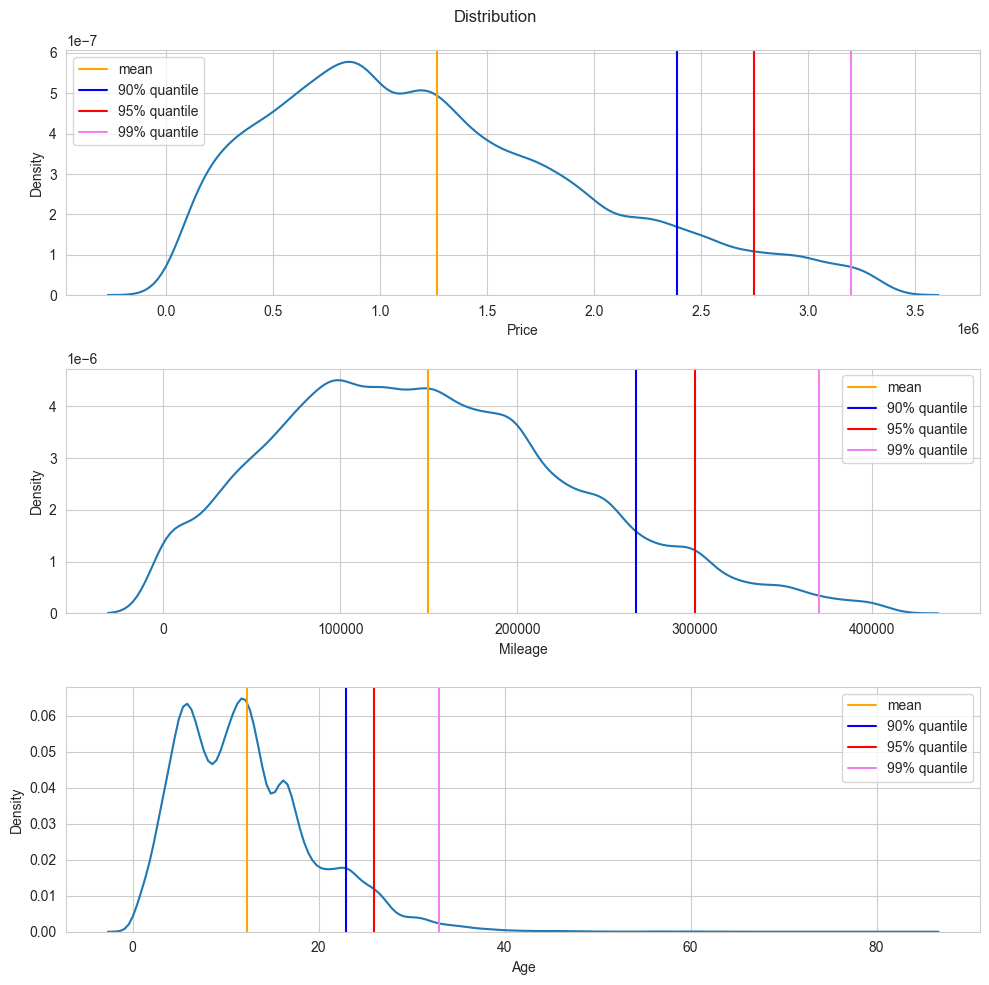

In [11]:
cars = cars.loc[cars['car_mileage'] < cars['car_mileage'].quantile(0.99)]
distribution()

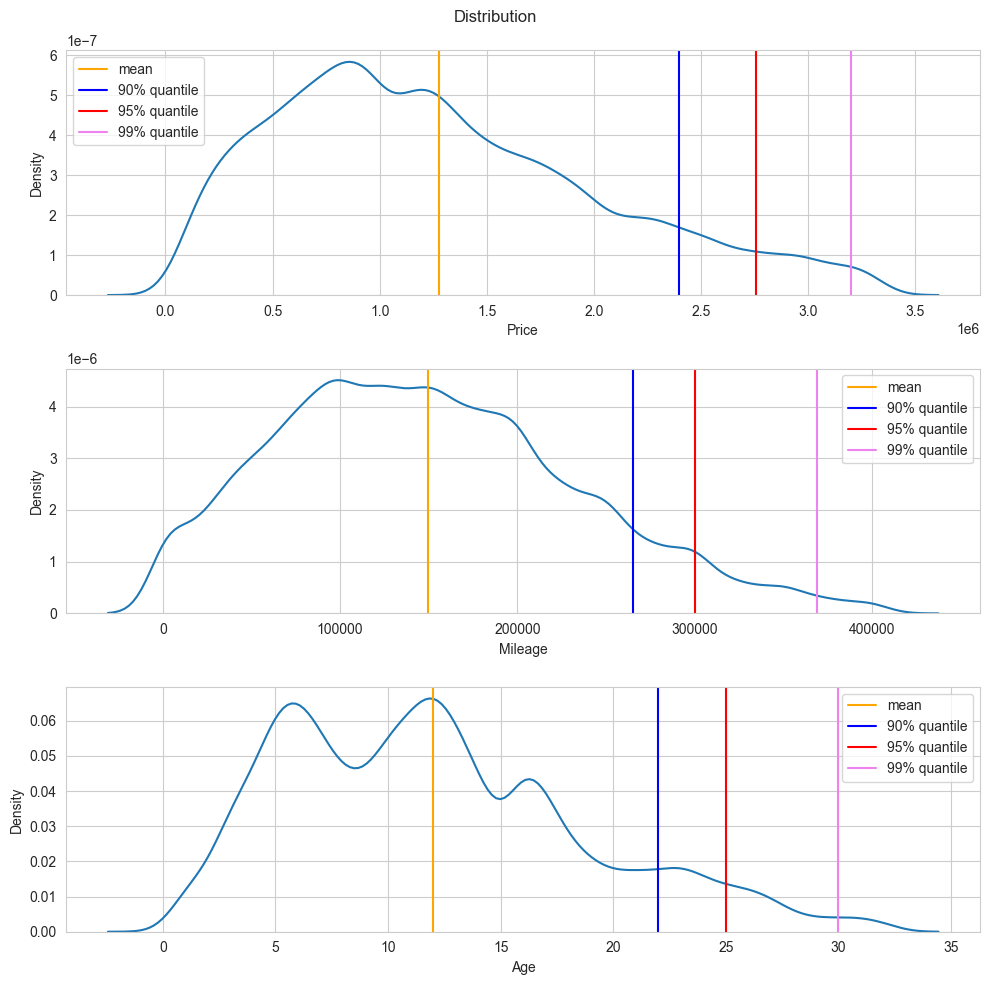

In [12]:
cars = cars.loc[cars['car_age'] < cars['car_age'].quantile(0.99)]
distribution()

In [13]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36887 entries, 0 to 42087
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   car_brand            36887 non-null  object 
 1   car_model            36887 non-null  object 
 2   car_price            36887 non-null  int64  
 3   car_fuel             36887 non-null  object 
 4   car_transmission     36887 non-null  object 
 5   car_drive            36887 non-null  object 
 6   car_mileage          36887 non-null  int64  
 7   car_engine_capacity  36887 non-null  float64
 8   car_engine_hp        36887 non-null  int64  
 9   car_age              36887 non-null  int64  
dtypes: float64(1), int64(4), object(5)
memory usage: 3.1+ MB


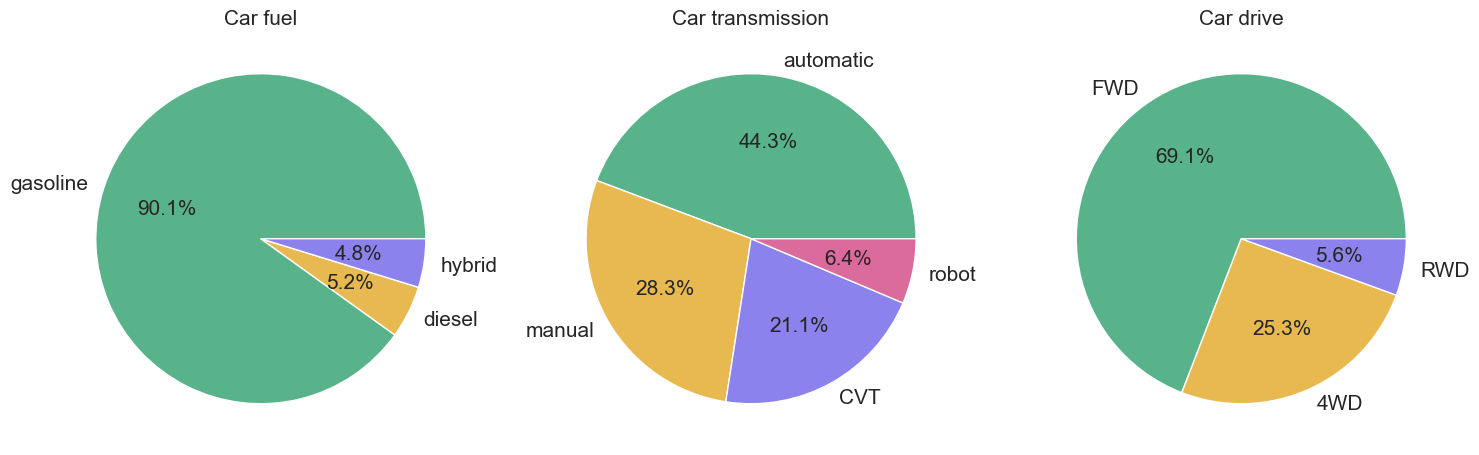

In [14]:
colors = ['#59b38a', '#e8b851', '#8b82ed', '#db6b9c']
textprops = {'fontsize': 15}

plt.figure(figsize=(15, 10))

plt.subplot(1, 3, 1)
plt.title('Car fuel', fontsize=15)
fuel_counts = cars['car_fuel'].value_counts()
fuel_labels = fuel_counts.index.tolist()
plt.pie(fuel_counts, autopct='%1.1f%%', labels=fuel_labels, colors=colors, textprops=textprops)

plt.subplot(1, 3, 2)
plt.title('Car transmission', fontsize=15)
transmission_counts = cars['car_transmission'].value_counts()
transmission_labels = transmission_counts.index.tolist()
plt.pie(transmission_counts, autopct='%1.1f%%', labels=transmission_labels, colors=colors, textprops=textprops)

plt.subplot(1, 3, 3)
plt.title('Car drive', fontsize=15)
drive_counts = cars['car_drive'].value_counts()
drive_labels = drive_counts.index.tolist()
plt.pie(drive_counts, autopct='%1.1f%%', labels=drive_labels, colors=colors, textprops=textprops)

plt.tight_layout()
plt.show()

In [15]:
cars = cars.loc[cars['car_fuel'] == 'gasoline']
cars.drop(['car_fuel'], axis=1, inplace=True)

cars.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33232 entries, 0 to 42087
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   car_brand            33232 non-null  object 
 1   car_model            33232 non-null  object 
 2   car_price            33232 non-null  int64  
 3   car_transmission     33232 non-null  object 
 4   car_drive            33232 non-null  object 
 5   car_mileage          33232 non-null  int64  
 6   car_engine_capacity  33232 non-null  float64
 7   car_engine_hp        33232 non-null  int64  
 8   car_age              33232 non-null  int64  
dtypes: float64(1), int64(4), object(4)
memory usage: 2.5+ MB


In [16]:
def show_diagram(data):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

    axes[0, 0].plot(data['car_mileage'], data['car_price'], 'rx', label='Actual')
    axes[0, 0].set_title('Car Mileage vs Price')
    axes[0, 0].legend()

    axes[0, 1].plot(data['car_age'], data['car_price'], 'rx', label='Actual')
    axes[0, 1].set_title('Car Age vs Price')
    axes[0, 1].legend()

    axes[1, 0].plot(data['car_engine_hp'], data['car_price'], 'rx', label='Actual')
    axes[1, 0].set_title('Car Engine HP vs Price')
    axes[1, 0].legend()

    axes[1, 1].plot(data['car_engine_capacity'], data['car_price'], 'rx', label='Actual')
    axes[1, 1].set_title('Car Engine Capacity vs Price')
    axes[1, 1].legend()

    plt.show()

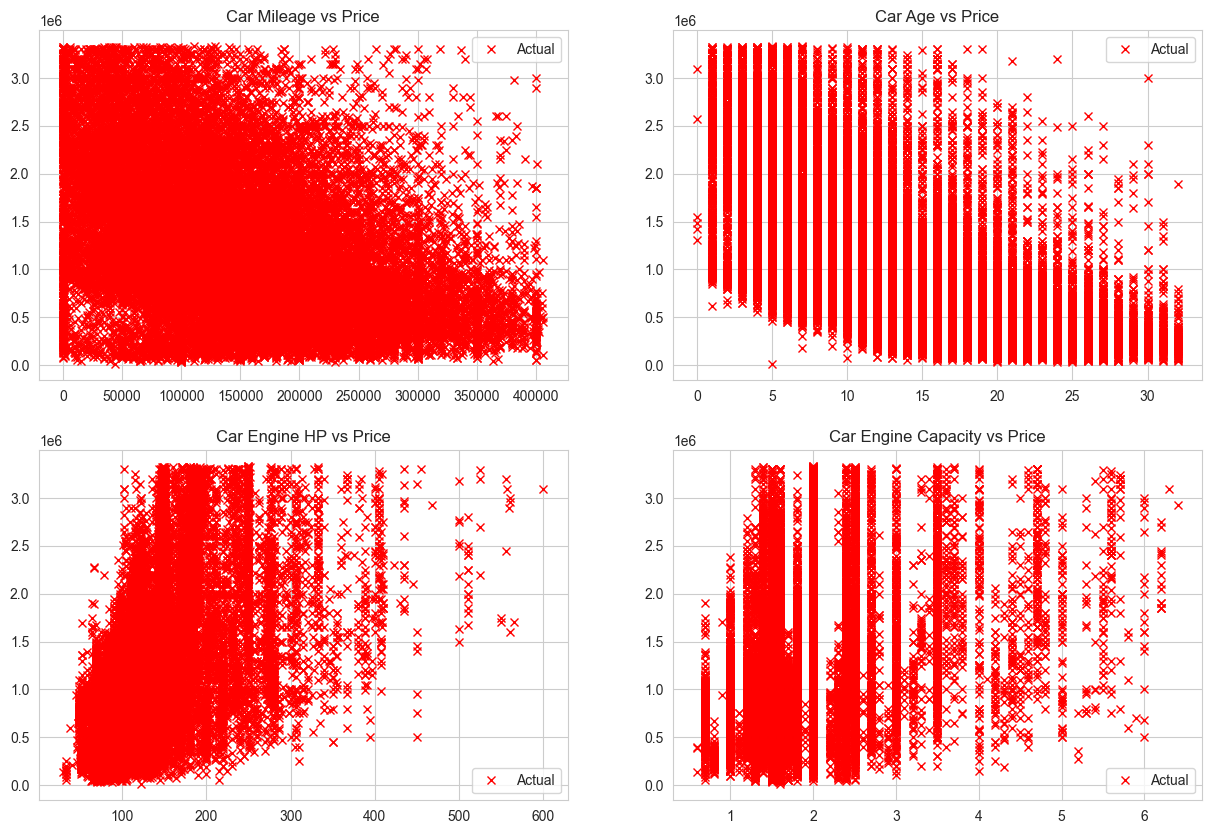

In [17]:
show_diagram(cars)

In [18]:
def show_mileage_age(data):
    plt.figure(figsize=(15, 10))

    age_max = data['car_age'].max()
    age_sum = data['car_age'].sum()
    mileage_sum = data['car_mileage'].sum()
    mean_mileage_per_age = mileage_sum / age_sum

    plt.plot(data['car_age'], data['car_mileage'], 'rx', )
    plt.plot([0, age_max], [0, age_max * mean_mileage_per_age], label='mean_mileage_per_age')
    plt.title('Car Age vs Mileage')
    plt.xlabel('Car Age')
    plt.ylabel('Car Mileage')

    plt.show()

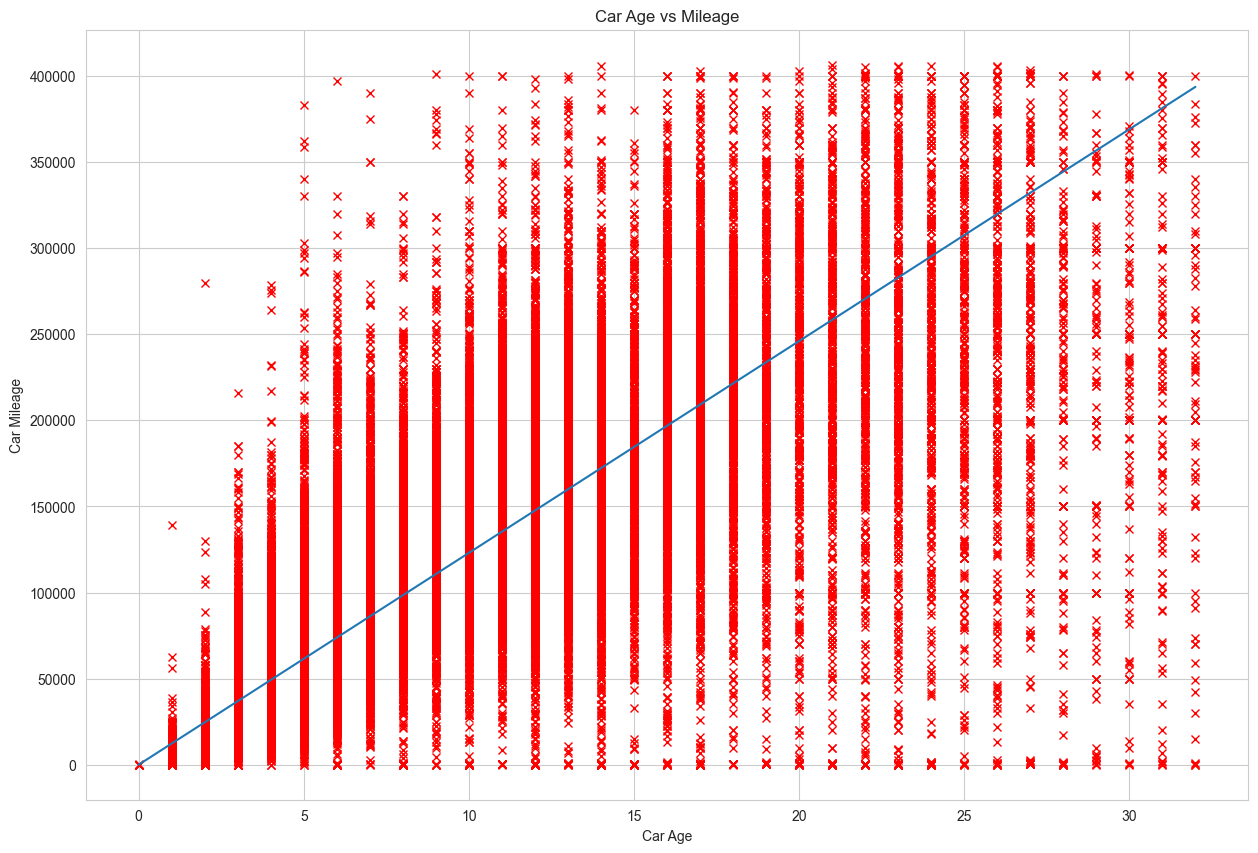

In [19]:
show_mileage_age(cars)

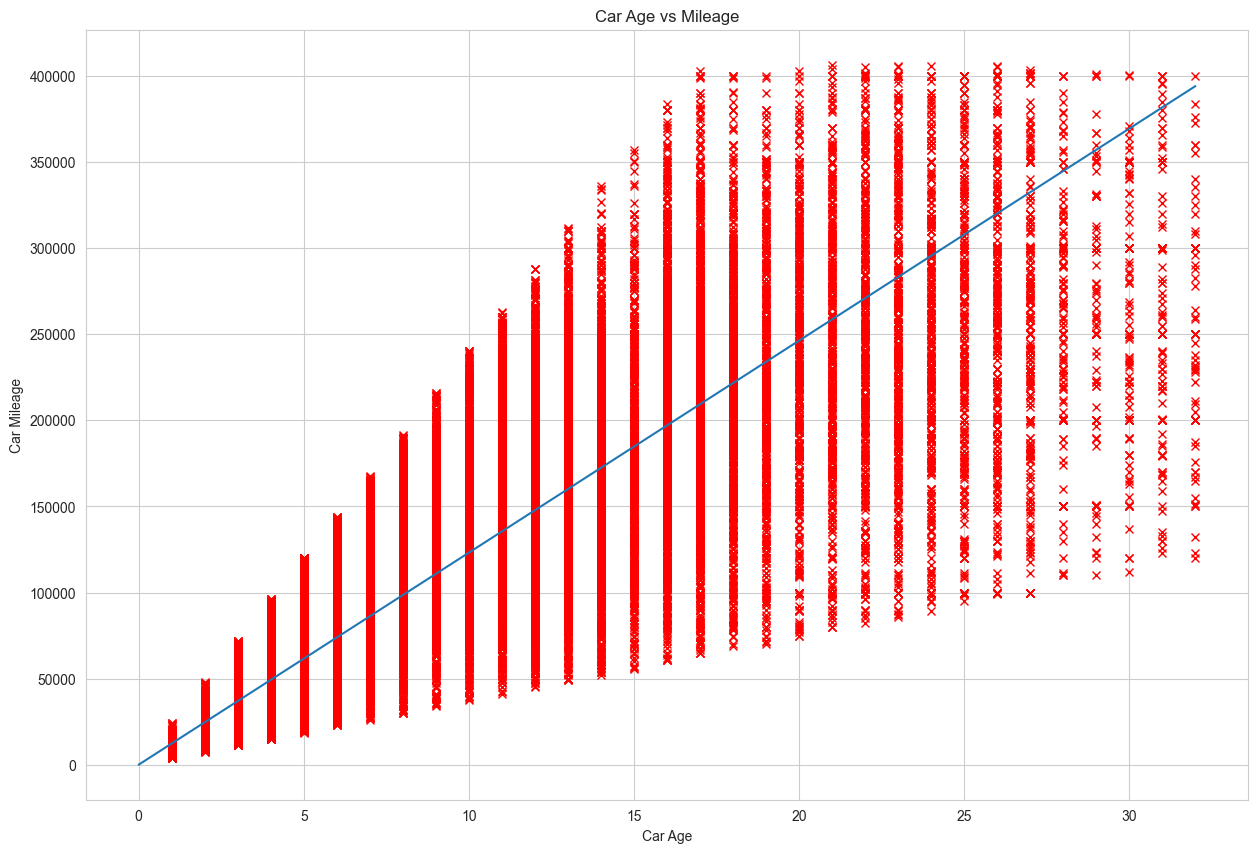

In [20]:
cars = cars.loc[(cars['car_mileage'] >= cars['car_age'] * 3700) & (cars['car_mileage'] <= cars['car_age'] * 24000)]

show_mileage_age(cars)

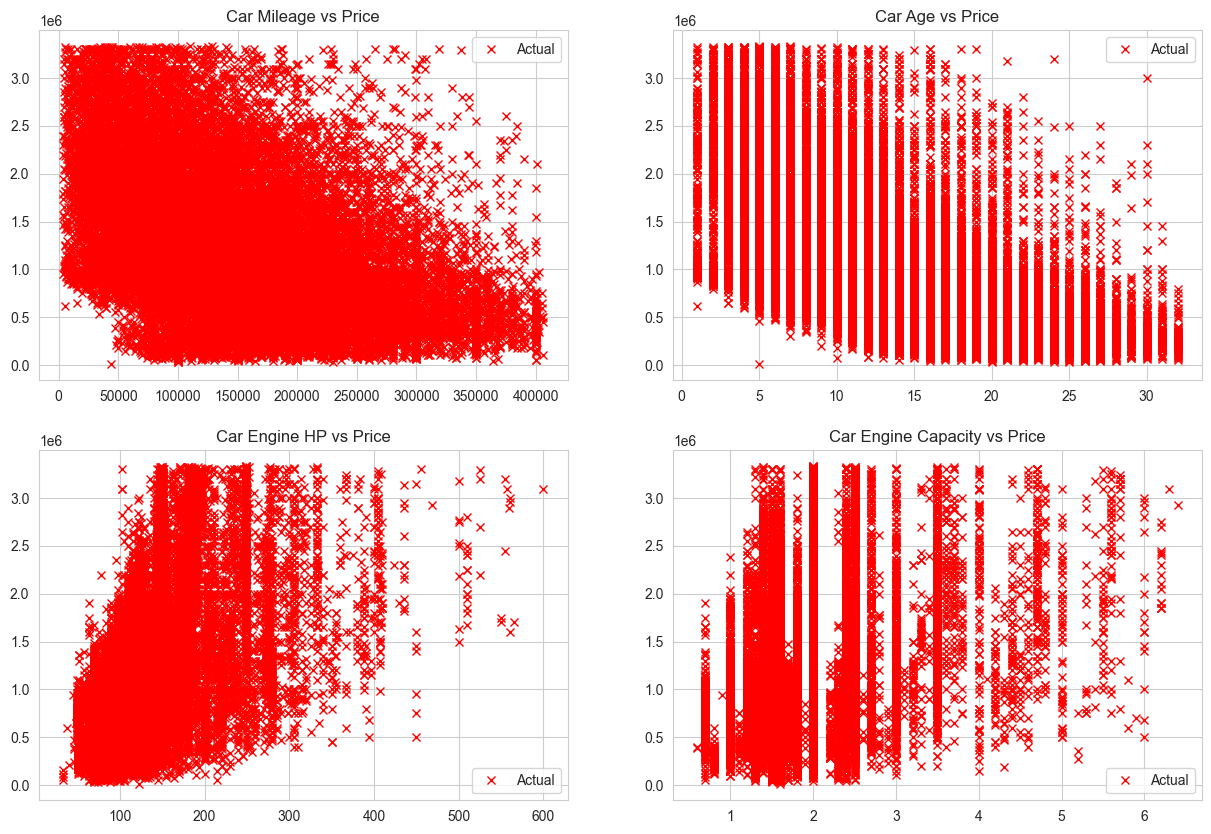

In [21]:
show_diagram(cars)

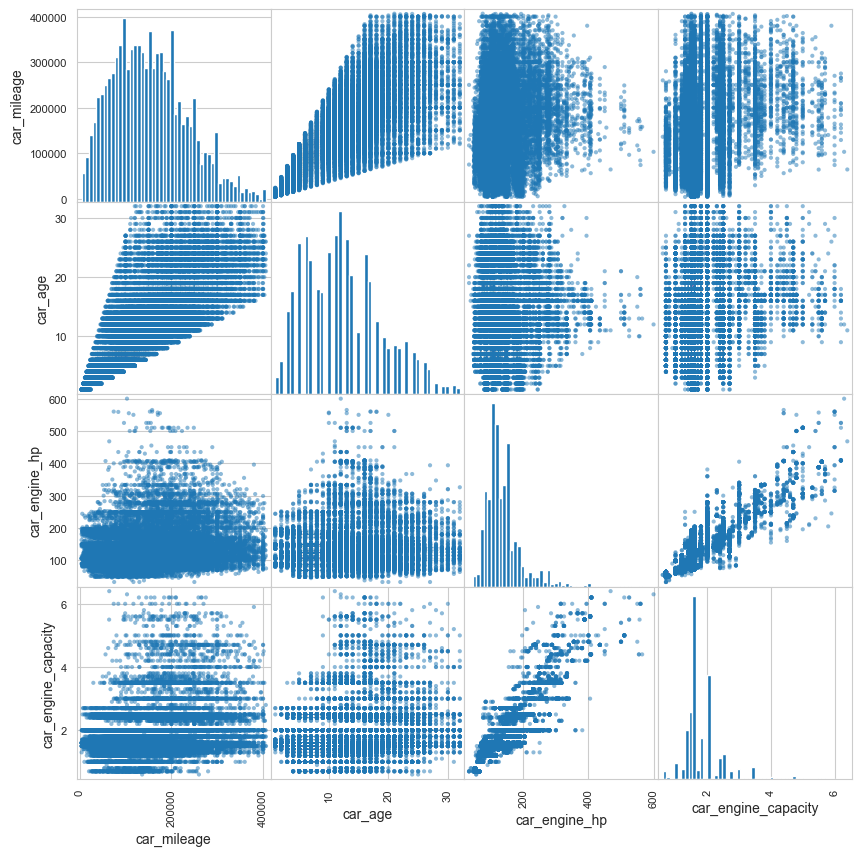

In [22]:
continuous_columns = ['car_mileage', 'car_age', 'car_engine_hp', 'car_engine_capacity']

discrete_columns = ['car_brand', 'car_model', 'car_transmission', 'car_drive']
discrete_columns.remove('car_drive')
discrete_columns.remove('car_transmission')

scatter_matrix(cars[continuous_columns], figsize=(10, 10), hist_kwds={'bins': 50});

In [23]:
def encode(data, encoder, columns=discrete_columns):
    data[columns] = encoder.fit_transform(data[columns])
    return data


def decode(data, encoder, columns=discrete_columns):
    data[columns] = encoder.inverse_transform(data[columns])
    return data

In [24]:
encoder = OrdinalEncoder()
# encoder = TargetEncoder()

cars = encode(cars, encoder, discrete_columns)

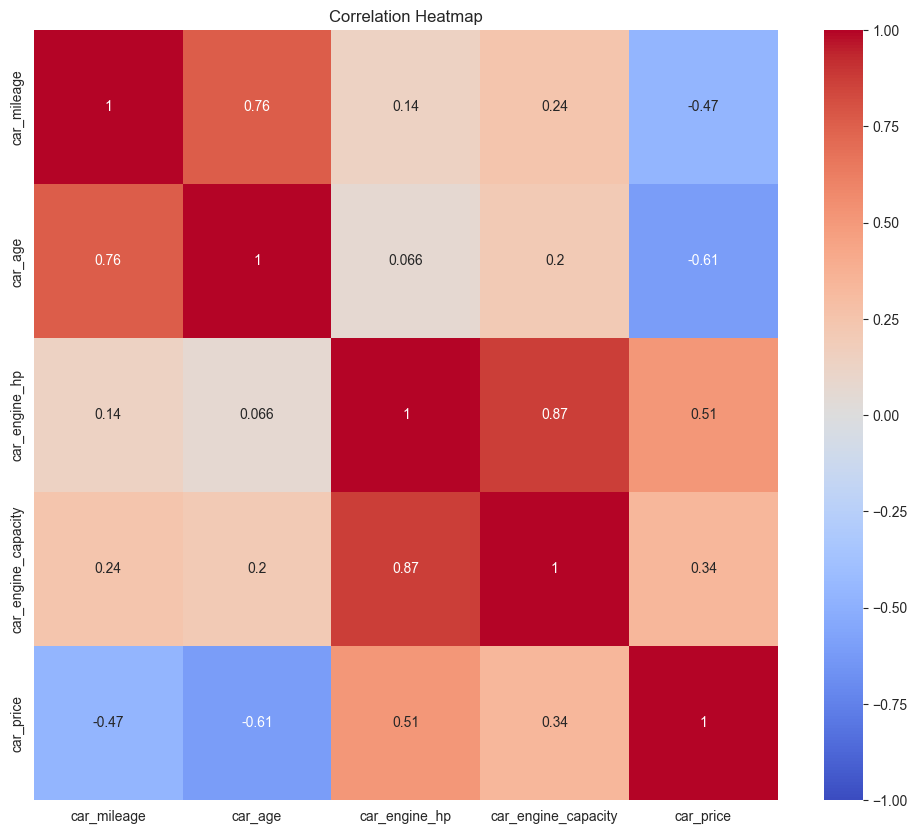

In [25]:
corr_matrix = cars[continuous_columns + ['car_price']].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Heatmap')
plt.show()

In [26]:
continuous_columns.remove('car_engine_capacity')

features = continuous_columns + discrete_columns

X = cars[features]
y = cars['car_price']

y.head()

0     550000
1    1820000
2    2600000
4    2125000
6    2539000
Name: car_price, dtype: int64

In [27]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30024 entries, 0 to 42087
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   car_mileage    30024 non-null  int64  
 1   car_age        30024 non-null  int64  
 2   car_engine_hp  30024 non-null  int64  
 3   car_brand      30024 non-null  float64
 4   car_model      30024 non-null  float64
dtypes: float64(2), int64(3)
memory usage: 1.4 MB


In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

pd.concat([X_train, y_train], axis=1).head()

,car_mileage,car_age,car_engine_hp,car_brand,car_model,car_price
6194,263840,15,140,39.0,965.0,869050
33901,202000,10,146,62.0,694.0,1555900
33708,80643,4,100,50.0,794.0,1530000
34720,246000,15,230,80.0,412.0,1450000
34822,370000,16,137,64.0,851.0,940000


In [29]:
model = RandomForestRegressor(max_depth=15)
# model = DecisionTreeRegressor()
# model = CatBoostRegressor()
# lr = LinearRegression()

model.fit(X_train, y_train)

# param_grid = {
#     'max_depth': [None, 5, 10, 15, 20, 25, 30]
# }
# 
# grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy')
# grid_search.fit(X_train, y_train)
# print(lr.coef_)

RandomForestRegressor(max_depth=15)

In [30]:
# results = pd.DataFrame(grid_search.cv_results_)
# print(results[['param_max_depth', 'mean_test_score', 'std_test_score', 'rank_test_score']])
# 
# best_max_depth = grid_search.best_params_['max_depth']
# print("Độ sâu tối ưu:", best_max_depth)

In [31]:
y_predict = model.predict(X_test)
y_train_predict = model.predict(X_train)

print(y_predict)

[1595877.47559159 1100905.05842577  369710.65266089 ... 1061084.11052862
 1477573.48713696 2409114.0290745 ]


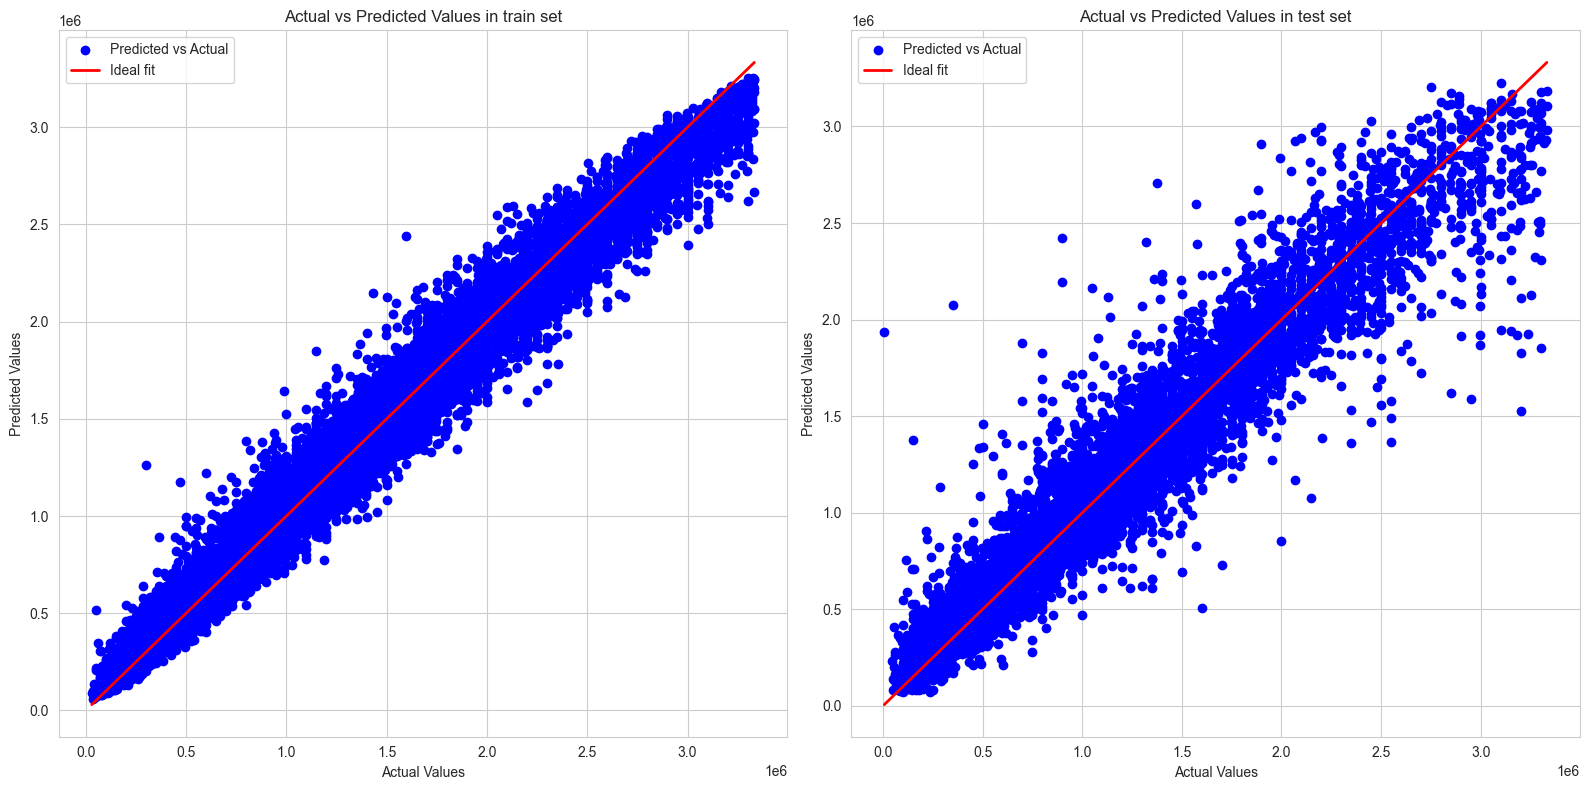

In [32]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

axes[0].scatter(y_train, y_train_predict, color='blue', label='Predicted vs Actual')
axes[0].plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color='red', linewidth=2, label='Ideal fit')
axes[0].set_xlabel('Actual Values')
axes[0].set_ylabel('Predicted Values')
axes[0].set_title('Actual vs Predicted Values in train set')
axes[0].legend()

axes[1].scatter(y_test, y_predict, color='blue', label='Predicted vs Actual')
axes[1].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linewidth=2, label='Ideal fit')
axes[1].set_xlabel('Actual Values')
axes[1].set_ylabel('Predicted Values')
axes[1].set_title('Actual vs Predicted Values in test set')
axes[1].legend()

fig.tight_layout()

plt.show()

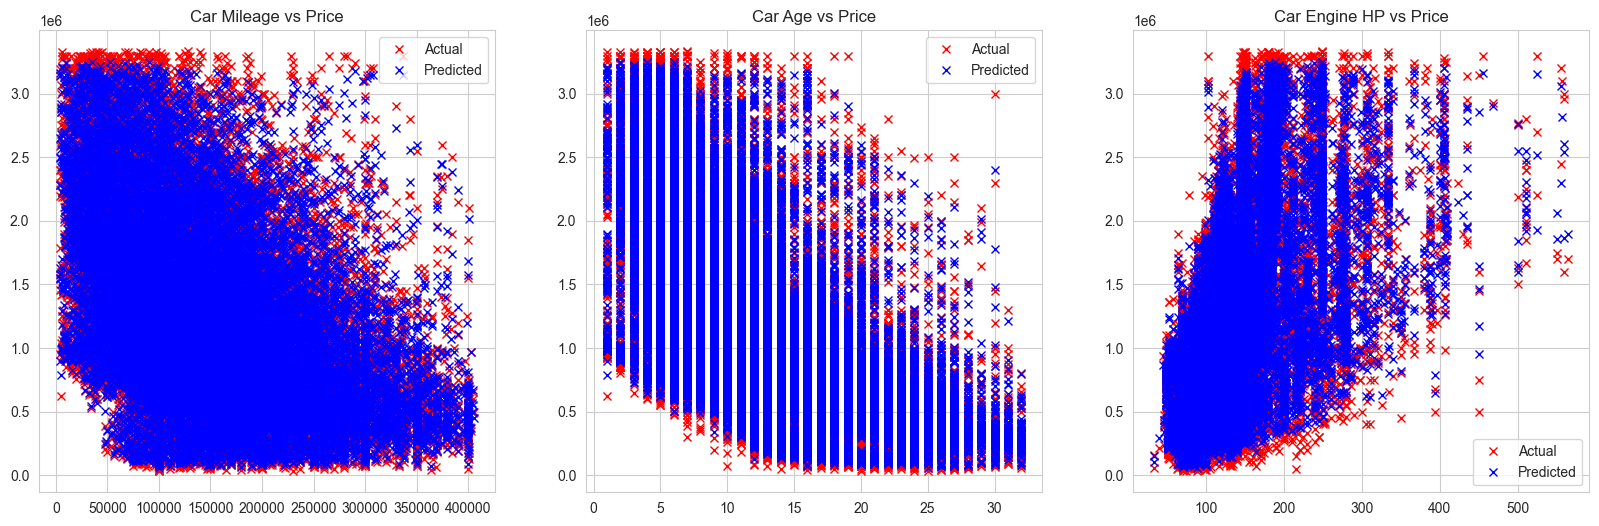

In [33]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))

axes[0].plot(X_train['car_mileage'], y_train, 'rx', label='Actual')
axes[0].plot(X_train['car_mileage'], y_train_predict, 'bx', label='Predicted')
axes[0].set_title('Car Mileage vs Price')
axes[0].legend()

axes[1].plot(X_train['car_age'], y_train, 'rx', label='Actual')
axes[1].plot(X_train['car_age'], y_train_predict, 'bx', label='Predicted')
axes[1].set_title('Car Age vs Price')
axes[1].legend()

axes[2].plot(X_train['car_engine_hp'], y_train, 'rx', label='Actual')
axes[2].plot(X_train['car_engine_hp'], y_train_predict, 'bx', label='Predicted')
axes[2].set_title('Car Engine HP vs Price')
axes[2].legend()

# axes[1, 1].plot(X_train['car_engine_capacity'], y_train, 'rx', label='Actual')
# axes[1, 1].plot(X_train['car_engine_capacity'], y_train_predict, 'bx', label='Predicted')
# axes[1, 1].set_title('Car Engine Capacity vs Price')
# axes[1, 1].legend()

# Hiển thị biểu đồ
plt.show()

In [34]:
feature_importances = pd.DataFrame({'Labels': features, 'Values': model.feature_importances_})

print(feature_importances.sort_values(by='Values', ascending=False))

          Labels    Values
2  car_engine_hp  0.463648
1        car_age  0.392912
4      car_model  0.056050
3      car_brand  0.047291
0    car_mileage  0.040099


In [35]:
r2 = sm.r2_score(y_test, y_predict)
mae_train = round(sm.mean_absolute_error(y_train, y_train_predict), 2)
mse_train = round(sm.mean_squared_error(y_train, y_train_predict), 2)
rmse_train = round(np.sqrt(mse_train), 2)

mae_test = round(sm.mean_absolute_error(y_test, y_predict), 2)
mse_test = round(sm.mean_squared_error(y_test, y_predict), 2)
rmse_test = round(np.sqrt(mse_test), 2)

# model_evaluation = pd.DataFrame({
#     'R-squared (R2)': [r2],
#     'MAE - Train': [mae_train],
#     'MSE - Train': [mse_train],
#     'RMSE - Train': [rmse_train],
#     'MAE - Test': [mae_test],
#     'MSE - Test': [mse_test],
#     'RMSE - Test': [rmse_test]
# })
# 
# model_evaluation
print("R²: ", r2)
print()
print("Mean Absolute Error (MAE) - Train: ", mae_train)
print("Mean Squared Error (MSE) - Train: ", mse_train)
print("Root Mean Squared Error (RMSE) - Train: ", rmse_train)
print()
print("Mean Absolute Error (MAE): - Test", mae_test)
print("Mean Squared Error (MSE): - Test", mse_test)
print("Root Mean Squared Error (RMSE) - Test: ", rmse_test)



R²:  0.912433144776895

Mean Absolute Error (MAE) - Train:  81714.49
Mean Squared Error (MSE) - Train:  12629642085.25
Root Mean Squared Error (RMSE) - Train:  112381.68

Mean Absolute Error (MAE): - Test 146412.4
Mean Squared Error (MSE): - Test 45946475821.07
Root Mean Squared Error (RMSE) - Test:  214351.29


In [36]:
# def to_list(group):
#     return group['car_model'].unique().tolist()
# 
# 
# cars = decode(cars, encoder)
# 
# brand_groups = cars.groupby('car_brand').apply(to_list).to_dict()

In [37]:
# import joblib
# 
# # model.feature_names = ['car_mileage', 'car_age', 'car_engine_hp']
# joblib.dump((model, encoder, features, discrete_columns, brand_groups),
#             "D:/STD/Python/fastApiProject/Model_Encoder_Features_Discrete_column_Brand_groups.pkl")


In [38]:
# model_backup = joblib.load("D:/STD/Python/fastApiProject/model.pkl")
# 
# model_backup.predict([[1, 2, 3, 1.6]])

In [39]:
# dfTest = pd.DataFrame({
#     "car_mileage": [10000],
#     "car_age": [2],
#     "car_engine_hp": [300],
#     "car_engine_capacity": [1.6]
# })
# 
# model_backup.predict(dfTest)

In [40]:
# encoded_mapping = {col: dict(zip(encoder.categories_[i], range(len(encoder.categories_[i])))) for i, col in
#                    enumerate(discrete_columns)}
# 
# # In ra kết quả
# for column, mapping in encoded_mapping.items():
#     print(f"Column: {column}")
#     print(mapping)

In [41]:
# model, encoder, features, discrete_columns, brand_groups = joblib.load(
#     "D:/STD/Python/fastApiProject/Model_Encoder_Features_Discrete_column_Brand_groups.pkl")

In [42]:
# print(list(brand_groups.keys()))

In [43]:
# from sklearn.tree import plot_tree
# 
# estimator = model.estimators_[0]
# 
# # Vẽ cây quyết định
# plt.figure(figsize=(20, 10))
# plot_tree(estimator, feature_names=features, filled=True)
# plt.show()

In [44]:
print(cars['car_mileage'].mean())

152819.4007793765
